In [3]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [4]:
# import data from CA, CT, TX, FL, NY, NJ 
ca = pd.read_csv('data/ca_ev_registrations_public.csv')
# nj = pd.read_csv('data/nj_ev_registrations_public.csv')
# ny = pd.read_csv('data/ny_ev_registrations_public.csv')
# tx = pd.read_csv('data/tx_ev_registrations_public.csv')
# fl = pd.read_csv('data/fl_ev_registrations_public.csv')
# ct = pd.read_csv('data/ct_ev_registrations_public.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [1]:
# ca.info()
# # 2542443 entries in CA
# nj.info()
# # NJ has 309872 entries
# ny.info()
# tx.info()
# ct.info()
# fl.info()
# # ca['Registration Valid Date'].value_counts()

In [5]:
# Create Data frame with years and amount of registered vehicles in that year
ca_years = pd.DataFrame(ca['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])
ca_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Year                 11 non-null     object
 1   Registered Vehicles  11 non-null     object
dtypes: object(2)
memory usage: 304.0+ bytes


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11 entries, 2020-01-01 to 2010-01-01
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Registered Vehicles  11 non-null     object
dtypes: object(1)
memory usage: 176.0+ bytes


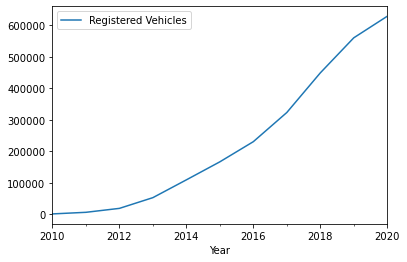

In [6]:
# As we can see, data is not stationary. 
ca_df = pd.DataFrame(ca_years['Registered Vehicles'])
ca_df = ca_df.set_axis(pd.to_datetime(ca_years['Year']))
ca_df.plot()
ca_df.info()
ca_df = ca_df.sort_values(by=['Registered Vehicles'], ascending = True)

In [10]:
ca_df = ca_df.resample('M').ffill()

<AxesSubplot:xlabel='Year'>

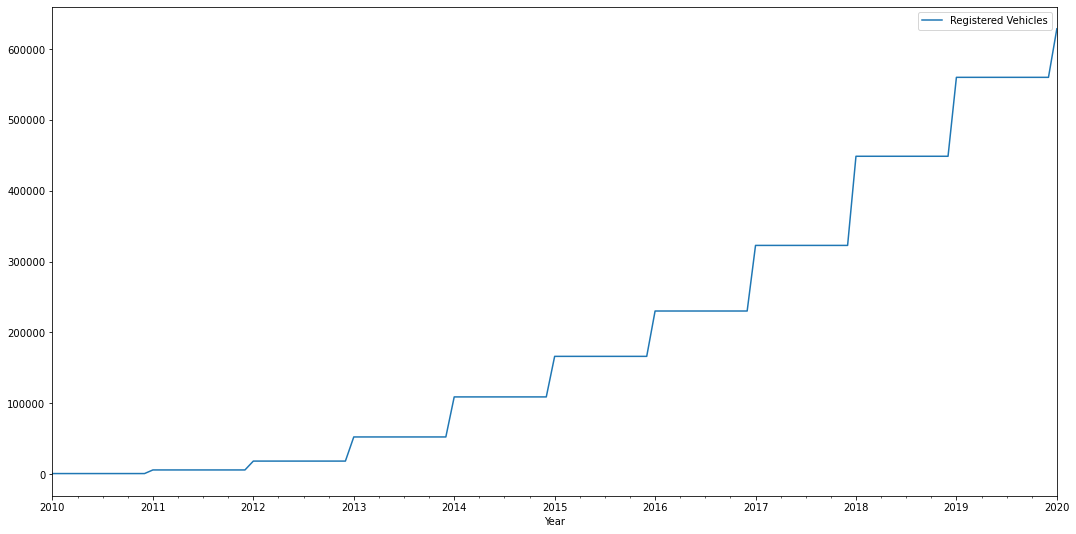

In [32]:
ca_df.plot()

In [11]:
catest = adfuller(ca_df)
display(catest)
# P value changed when resampled to Months 
# Pvalue - 0.41624347392997485

(-1.2631926963710787,
 0.6458390464019452,
 12,
 108,
 {'1%': -3.4924012594942333,
  '5%': -2.8886968193364835,
  '10%': -2.5812552709190673},
 2217.2330623438343)

In [12]:
ca_df = ca_df.astype(float)
ca_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 2010-01-31 to 2020-01-31
Freq: M
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Registered Vehicles  121 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [27]:
catrain = ca_df['2010':'2018']
catest = ca_df['2019':'2020']
combined = ca_df

catrain

,Registered Vehicles
Year,
2010-01-31,754.0
2010-02-28,754.0
2010-03-31,754.0
2010-04-30,754.0
2010-05-31,754.0
...,...
2018-08-31,448567.0
2018-09-30,448567.0
2018-10-31,448567.0


In [28]:
auto_modelca = pm.auto_arima(catrain, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_modelca.summary())

# (2,0,1), (0,0,0) , [0]

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2956.642, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2886.529, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2439.440, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2438.438, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2440.143, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2440.182, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2441.435, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2440.028, Time=0.14 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 1.067 seconds
                               SARIMAX Results                                
Dep. Variable:               

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9971      0.099     20.202      0.000       1.803       2.191
ar.L2         -0.9963      0.102     -9.767      0.000      -1.196      -0.796
ma.L1         -1.0079      0.186     -5.419      0.000      -1.372      -0.643
sigma2      3.321e+08   8.11e-10   4.09e+17      0.000    3.32e+08    3.32e+08


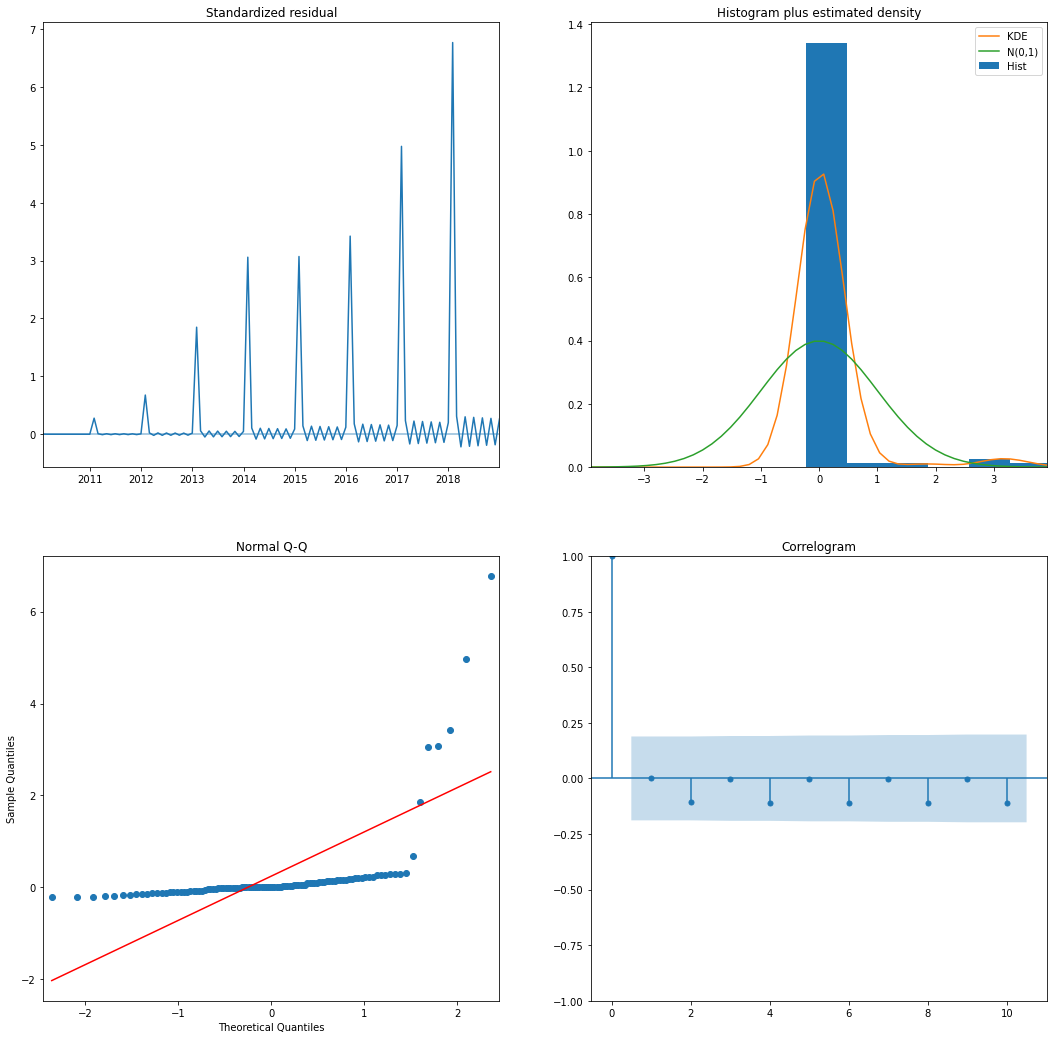

In [29]:
ARIMA_MODELCA = sm.tsa.statespace.sarimax.SARIMAX(catrain, 
                                        order=(2,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


outputca = ARIMA_MODELCA.fit()

print(outputca.summary().tables[1])
auto_modelca.plot_diagnostics(figsize=(18,18))
plt.show()

In [30]:
predca = outputca.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2020-01-31'), dynamic=False)
pred_confca = predca.conf_int()
pred_confca

,lower Registered Vehicles,upper Registered Vehicles
2019-01-31,423852.136168,495600.301550
2019-02-28,420509.748816,521879.626926
2019-03-31,420946.353320,545013.663898
2019-04-30,423489.011684,566690.980545
2019-05-31,427491.138979,587574.229157
2019-06-30,432623.001351,608009.658861
2019-07-31,438690.688933,628208.153649
2019-08-31,445569.811127,648311.548342
2019-09-30,453175.868641,668422.268111
2019-10-31,461449.181335,688618.412527


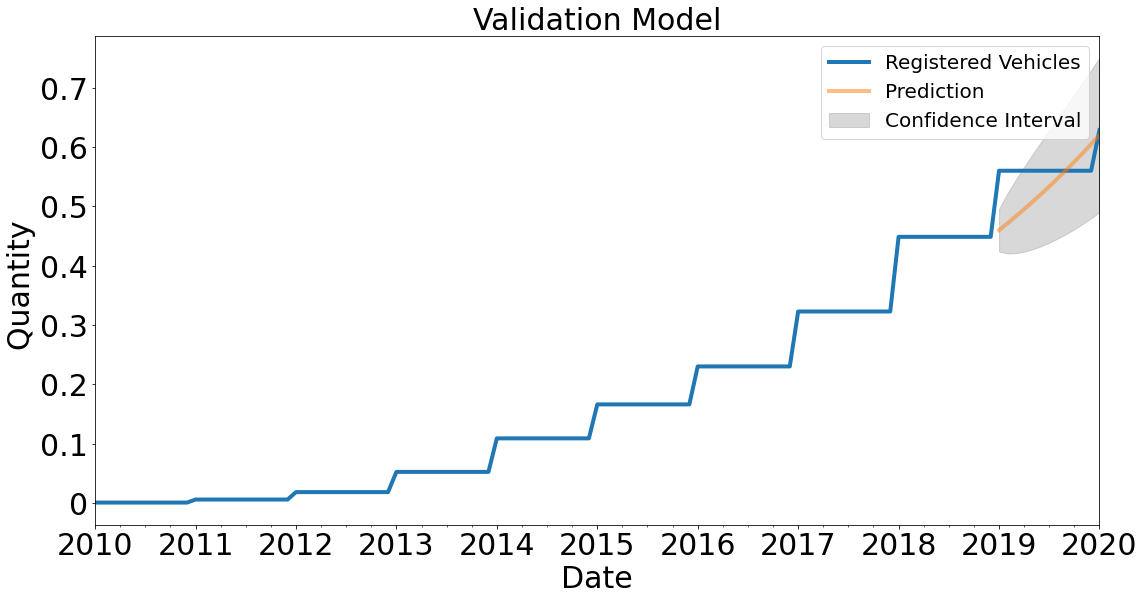

In [31]:


rcParams['figure.figsize'] = 18, 9
ax = ca_df.plot(label='observed', linewidth = 4)

predca.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_confca.index,
                pred_confca.iloc[:, 0],
                pred_confca.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity ',fontsize=30)
plt.yticks(fontsize=30)
#Changing the y scale to ($) Millions
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [15]:

# ca_df.head()

Year
2020-01-01    628473.0
2019-01-01    559969.0
2018-01-01    448567.0
2017-01-01    322762.0
2016-01-01    230171.0
Name: Registered Vehicles, dtype: float64

In [ ]:
# Differencing to be stationary 
# ca_diff = ca_df.diff().dropna()
# ca_diff.plot()

In [ ]:
cadifftest = adfuller(ca_diff)
display(cadifftest)
# Pvalue -  0.9754235581948372

In [ ]:

# plot_acf(ca_diff, ax=ax, lags = 3)

#### Lets take the necessary data from each of the data frames - specifically date, and convert them into a usable format as they are currently 'objects' and need them to be in datetime format for analyses